# Data: Elliptic Data Set
The Elliptic Dataset is a graph network of Bitcoin transactions with handcrafted features. All features are constructed using only publicly available information.

The Elliptic DataSet maps Bitcoin transactions to real entities in two categories:

Licit: exchanges, wallet providers, miners, licit services, etc.
Ilicit: scams, malware, terrorist, organization, ransomware, Ponzi shcemes, etc
A given transaction is licit if the entity that generated it was licit.

Nodes and Edges 203,769 node transactions and 234,355 directed edge payments flows. 2% are ilicit (Class 1), 21% are licit (Class 2)
Features Each node has associated 166 features. 94 represent local information (timestep, number of inputs/outputs, transaction fee, output volume and aggregated figures) and 72 features represent aggregated features (obtained by aggregating transaction information such as maximum, minimum, standard deviation, correlation coefficients of neighbor transactions).
Temporal Information A time step is associated with each node, representing an stimated of the time when the transaction is confirmed. There are 49 distinct timesteps evenly spaced with an interval of 2 weeks.

# Our Mehtods
1. We use PCA to reduce dimension characteristics

2. Experiments are done on different classifiers

> Supervised: KNN, Bayes, SVM, Decision Tree
 
> Unsupervised: Kmeans, DBSCAN
 
> Semi-supervised: ANN

3. Evaluation matrix The confusion matrix was used to calculate the accuracy, precision, recall, F-1score, ROC curve and AUC area

4. Select the best method to predict unknown tags



# 0. Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import sys
import time
from tqdm import tqdm

import scipy
import scipy.cluster.hierarchy as sch
from scipy import interp
from scipy.cluster.vq import vq,kmeans,whiten

#import sklearn.datasets as datasets
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.preprocessing import LabelBinarizer

from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score  
from sklearn.metrics import precision_score    
from sklearn.metrics import recall_score      
from sklearn.metrics import f1_score         
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier

from itertools import cycle

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense,Dropout

# 1. Dataset

Labels:
* 'Unknown' -- 0
* 'Ilicit' -- 1
* 'Licit' -- 2

In [2]:
df_classes = pd.read_csv("../input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_txs_classes.csv")
df_edges = pd.read_csv("../input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv")
df_features = pd.read_csv("../input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_txs_features.csv", header=None)

In [3]:
colNames1 = {'0': 'txId', 1: "Time step"}
colNames2 = {str(ii+2): "Local_feature_" + str(ii+1) for ii in range(93)}
colNames3 = {str(ii+95): "Aggregate_feature_" + str(ii+1) for ii in range(72)}

colNames = dict(colNames1, **colNames2, **colNames3 )
colNames = {int(jj): item_kk for jj,item_kk in colNames.items()}

df_features = df_features.rename(columns=colNames)

In [4]:
df_classes.loc[df_classes['class'] == 'unknown', 'class'] = 0
print('Shape of classes', df_classes.shape)
print('Shape of edges', df_edges.shape)
print('Shape of features', df_features.shape)

Shape of classes (203769, 2)
Shape of edges (234355, 2)
Shape of features (203769, 167)


In [5]:
# Merge Class and features
df_class_feature = pd.merge(df_classes, df_features )
df_class_feature.head()

,txId,class,Time step,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,...,Aggregate_feature_63,Aggregate_feature_64,Aggregate_feature_65,Aggregate_feature_66,Aggregate_feature_67,Aggregate_feature_68,Aggregate_feature_69,Aggregate_feature_70,Aggregate_feature_71,Aggregate_feature_72
0,230425980,0,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,0,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,0,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,2,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,0,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


# 2. Exploratory Data Analysis (EDA)

<BarContainer object of 3 artists>

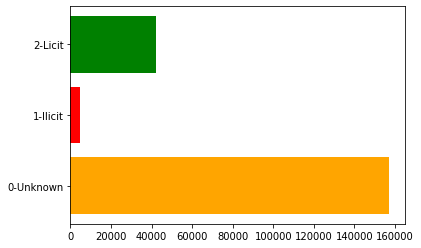

In [6]:
group_class = df_classes.groupby('class').count()
plt.barh(['0-Unknown', '1-Ilicit', '2-Licit'], group_class['txId'].values, color=['orange', 'r', 'g'] )

We can see that the data distribution is not uniform, and we are concerned about whether the class is legitimate for a small sample in the data set.

<AxesSubplot:xlabel='Time step'>

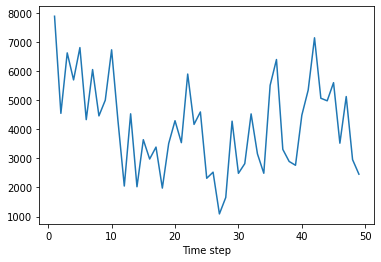

In [7]:
group_feature = df_features.groupby('Time step').count()
group_feature['txId'].plot()
#plt.title('Number of transactions by Time step')

We can see that with the change of time step, the fluctuation of trading is also very large, and there is a trough value at 20-30time step.

In [8]:
group_class_feature = df_class_feature.groupby(['Time step', 'class']).count()
#plt.barh(['Unknown', 'Ilicit', 'Licit'], group_class['txId'].values, color=['orange', 'r', 'g'] )
group_class_feature = group_class_feature['txId'].reset_index().rename(columns={'txId': 'count'})#unstack()
group_class_feature.head()

,Time step,class,count
0,1,0,5733
1,1,1,17
2,1,2,2130
3,2,0,3427
4,2,1,18


<AxesSubplot:xlabel='Time step', ylabel='count'>

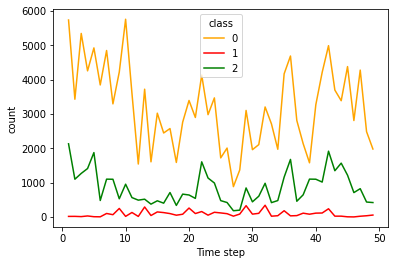

In [9]:
sns.lineplot(x='Time step', y='count', hue='class', data = group_class_feature, palette=['orange', 'r', 'g'] )

Each label changes with the timestep, the change fluctuation of the transaction. As you can see, the fluctuation trends of 0-unknown and 2-Licit are similar, while 1-Ilicit maintains a steady trend of low-frequency trading, small fluctuations,

Text(0.5, 0, 'Time step')

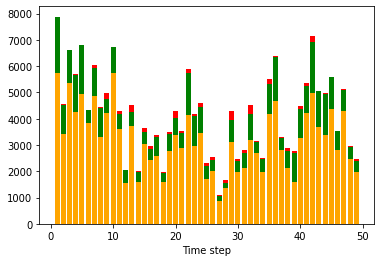

In [10]:
class1 = group_class_feature[group_class_feature['class'] == '1']
class2 = group_class_feature[group_class_feature['class'] == '2']
class3 = group_class_feature[group_class_feature['class'] == 0 ]

p1 = plt.bar(class3['Time step'], class3['count'], color = 'orange')

p2 = plt.bar(class2['Time step'], class2['count'], color='g',
             bottom=class3['count'])

p3 = plt.bar(class1['Time step'], class1['count'], color='r',
             bottom=np.array(class3['count'])+np.array(class2['count']))

plt.xlabel('Time step')

The chart above shows the proportion of each type of transaction in each timestep.

# 3. Processing of data

Firstly, dimension reduction is completed through ***PCA***. When supervised and semi-supervised classifiers are used, data sets need to be shred ***(7:3 is adopted)***. This operation is ***unnecessary*** for unsupervised classifiers, and data sets after PCA are directly used.

**all_X** is for unsupervised classifiers

**x_train** and **x_test** is for supervised and semi-supervised classifiers

## 3.1 PCA

pca.components_ (165, 165)
pca_var_ratio (165,)


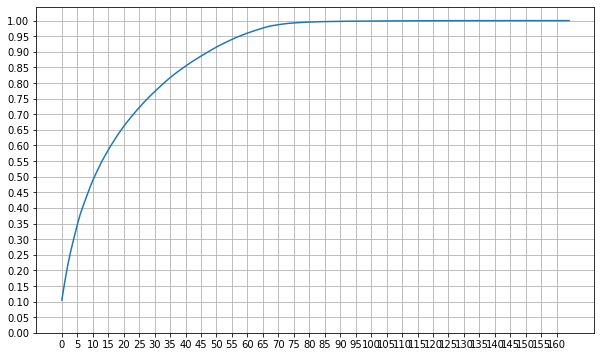

In [11]:
bfPCA_X = df_class_feature.drop(columns=['txId', 'Time step','class'])

if __name__ == '__main__':
    y=df_class_feature['class'].values
    y = y.astype('int')
    y=y.astype(np.int32)
    pca=PCA( )
    #pca=PCA(n_components=0.9)
    pca.fit(bfPCA_X,y)
    ratio=pca.explained_variance_ratio_
    print("pca.components_",pca.components_.shape)
    print("pca_var_ratio",pca.explained_variance_ratio_.shape)
    #绘制图形
    plt.figure (figsize= (10, 6))
    plt.plot([i for i in range(bfPCA_X.shape[1])],
             [np.sum(ratio[:i+1]) for i in range(bfPCA_X.shape[1])])
    plt.xticks(np.arange(bfPCA_X.shape[1],step=5))
    plt.yticks(np.arange(0,1.01,0.05))
    plt.grid()
    plt.show()

Abscissa: indicates the number of reserved dimensions

Ordinate: Sum of variance of all components after dimension reduction

The following figure can help us choose the appropriate target dimensions. We can find that with the increase of the number of dimension reduction, the variance and proportion first increase rapidly and then increase steadily. When the number of dimensions after dimension reduction is 20, the sum of variance of all components is 90%, that is, about 10% of the information is lost.

In [12]:
%%time
pca = PCA(n_components=0.9) #n=49
all_X = pca.fit_transform(bfPCA_X)
#print(pca.explained_variance_ratio_)

print('Data dimensions after dimension reduction：',all_X.shape)
reconMat=pca.inverse_transform(all_X)
print("Reconstructed data dimensions：",reconMat.shape)

Data dimensions after dimension reduction： (203769, 49)
Reconstructed data dimensions： (203769, 165)
CPU times: user 11.6 s, sys: 1.79 s, total: 13.4 s
Wall time: 4.03 s


We chose to retain 90% of the information, and we chose to reduce the dimensions from 165 to 49.

## 3.2 Data cutting

In [13]:
y = y.astype('int')
type(y)

x_train, x_test , y_train, y_test = train_test_split(all_X, y, test_size = 0.3)

# 4. Evaluation Matrix


There are different calculation methods for ***average*** parameter in multiple classification problems, which can extend the research. In addition, the ROC and AUC calculations in multiple classifications require ***one-hot coding*** in advance.

In [14]:
def summary(Y_test,Y_hat):
    print('accuracy',accuracy_score(Y_test,Y_hat))
    print('precision',precision_score(Y_test,Y_hat,average='macro'))
    print('recall',recall_score(Y_test,Y_hat,average='macro'))
    print('f1_score',f1_score(Y_test,Y_hat,average='macro'))
    ###Calculate AUC
    ###One-hot encoding
    encoder = LabelBinarizer()
    Y_test_onehot = encoder.fit_transform(Y_test)
    Y_hat_onehot=encoder.fit_transform(Y_hat)
    print('AUC',roc_auc_score(Y_test_onehot,Y_hat_onehot,multi_class='ovr'))
    
    
    #Compute ROC curve and ROC area for each class
    nb_classes=3
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(nb_classes):
        fpr[i], tpr[i], _ = roc_curve(Y_test_onehot[:, i], Y_hat_onehot[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(nb_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(nb_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= nb_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    # Plot all ROC curves
    lw = 2
    plt.figure()

    plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(nb_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    #plt.savefig("../images/ROC/ROC_3分类.png")
    plt.show()

Graphs:

Ilicit transactions at time step 20

In [15]:
df_class_feature

,txId,class,Time step,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,...,Aggregate_feature_63,Aggregate_feature_64,Aggregate_feature_65,Aggregate_feature_66,Aggregate_feature_67,Aggregate_feature_68,Aggregate_feature_69,Aggregate_feature_70,Aggregate_feature_71,Aggregate_feature_72
0,230425980,0,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,0,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,0,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,2,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,0,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203764,173077460,0,49,-0.145771,-0.163752,0.463609,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.577099,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
203765,158577750,0,49,-0.165920,-0.123607,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,...,0.162722,0.010822,1.461330,1.461369,-0.098889,-0.087490,-0.084674,-0.140597,-1.760926,-1.760984
203766,158375402,1,49,-0.172014,-0.078182,1.018602,0.028105,-0.043875,0.054722,-0.061584,...,1.261246,1.985050,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
203767,158654197,0,49,-0.172842,-0.176622,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.397749,-0.411776,1.461330,1.461369,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399


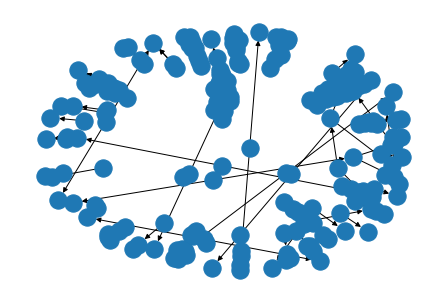

In [16]:
ilicit_ids = df_class_feature.loc[(df_class_feature['Time step'] == 20) & (df_class_feature['class'] == '1'), 'txId']
ilicit_edges = df_edges.loc[df_edges['txId1'].isin(ilicit_ids)]

graph = nx.from_pandas_edgelist(ilicit_edges, source = 'txId1', target = 'txId2', 
                                 create_using = nx.DiGraph())
pos = nx.spring_layout(graph)
nx.draw(graph, with_labels=False, pos=pos)

Prediction of ilicit transactions

# 5. Supervised Classifier

## 5.1 KNN 

参数选择

In [17]:
#parameter = {'n_neighbors':[1,3,5,7,9,11,13]}
#knn = KNeighborsClassifier()

#clf = GridSearchCV(knn,parameter,cv=5)
#clf.fit(x_train, y_train)

#print(f'best K value is：{(clf.best_params_)["n_neighbors"]}',"accuracy is：%.2f"%clf.best_score_)
"""best K value is：7 accuracy is：0.90
CPU times: user 47min 43s, sys: 14min 38s, total: 1h 2min 21s
Wall time: 50min 1s"""

'best K value is：7 accuracy is：0.90\nCPU times: user 47min 43s, sys: 14min 38s, total: 1h 2min 21s\nWall time: 50min 1s'

accuracy 0.9000507107686772
precision 0.8154012211555276
recall 0.7207378320247969
f1_score 0.7606918002641271
AUC 0.8012248486223116


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


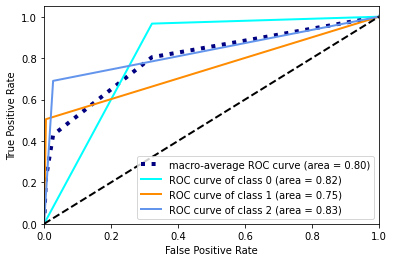

CPU times: user 3min 26s, sys: 1min 19s, total: 4min 45s
Wall time: 3min


In [18]:
%%time
knn = KNeighborsClassifier(n_neighbors=7)    
knn.fit(x_train, y_train)      
y_knn=knn.predict(x_test) 

summary(y_test,y_knn)

## 5.2 Bayes

Bayes doesn't need any parameters. The priors used are naive Bayes with Gaussian distribution. Generally speaking, GaussianNB is better if the distribution of sample features is mostly continuous. If most of the sample characteristics are multivariate discrete values, it is appropriate to use very high specification. If the sample features are binary discrete values or very sparse multivariate discrete values, BernoulliNB should be used.

accuracy 0.43954785624314996
precision 0.4659647309023544
recall 0.5569416062184606
f1_score 0.3747870455021765
AUC 0.6343859294886266


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


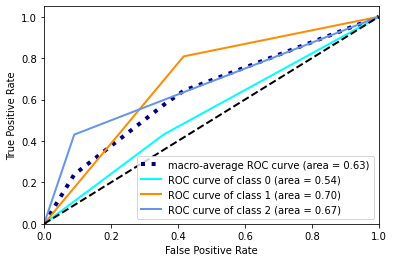

CPU times: user 620 ms, sys: 137 ms, total: 757 ms
Wall time: 514 ms


In [19]:
%%time
gnb = GaussianNB().fit(x_train, y_train)
y_nb=gnb.predict(x_test) 

summary(y_test,y_nb)

## 5.3 SVM

accuracy 0.9010485678297426
precision 0.5997223240695974
recall 0.5589627649178421
f1_score 0.5745600572571535
AUC 0.7152523650392633


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


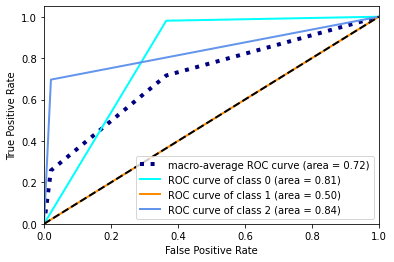

CPU times: user 23min 58s, sys: 761 ms, total: 23min 59s
Wall time: 23min 59s


In [20]:
%%time
clf_rbf = svm.SVC(kernel='rbf')
clf_rbf.fit(x_train, y_train)
y_rbf=clf_rbf.predict(x_test)

summary(y_test,y_rbf)

accuracy 0.8896304657211562
precision 0.7335288212860488
recall 0.5358814618890233
f1_score 0.5584526447575832
AUC 0.6929607894012535


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


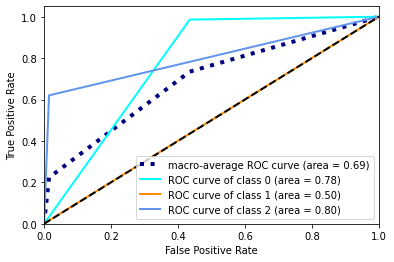

CPU times: user 48min 10s, sys: 1.1 s, total: 48min 11s
Wall time: 48min 11s


In [21]:
%%time
clf_poly = svm.SVC(kernel='poly')
clf_poly.fit(x_train, y_train)
y_poly=clf_poly.predict(x_test) 

summary(y_test,y_poly)

## 5.4 Decision Tree

accuracy 0.8456102468469353
precision 0.6831049103506212
recall 0.7012925590291731
f1_score 0.6918340984986054
AUC 0.7824031579031635


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


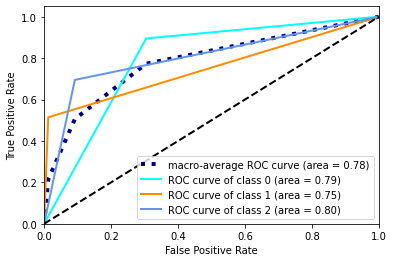

CPU times: user 28.8 s, sys: 181 ms, total: 29 s
Wall time: 28.8 s


In [22]:
%%time
clf_cart = DecisionTreeClassifier(random_state=0, criterion="gini")
clf_cart.fit(x_train, y_train)
y_cart=clf_cart.predict(x_test) 

summary(y_test,y_cart)

# 6. Unsupervised Classifier

## 6.1 K-means

accuracy 0.2231939107518808
precision 0.34205333007368605
recall 0.3517339166528272
f1_score 0.2047654236416719
AUC 0.5106283301923741


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


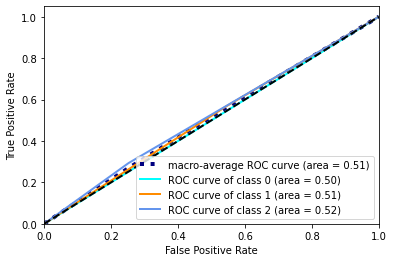

CPU times: user 1min 47s, sys: 1min 23s, total: 3min 10s
Wall time: 1min 2s


In [23]:
%%time
points = pd.DataFrame(all_X)
##The original data is normalized
data=whiten(points)
##The kmeans function is used for clustering. The first dimension is the data and the second dimension is the number of clustering k.
centroid = kmeans(data,3)[0]#3class
#print(centroid)
##The vq function is used to classify all data according to the clustering center. The output of vq is also two-dimensional, and [0] represents the label of all data
y_km=vq(data,centroid)[0]
#label

summary(y,y_km)

## 6.2 DBSCAN

In [24]:
#%%time
#def select_MinPts(data,k):
#    k_dist = []
#    for i in tqdm(range(data.shape[0])):
#        dist = (((data[i] - data)**2).sum(axis=1)**0.5)
#        dist.sort()
#        k_dist.append(dist[k])
#    return np.array(k_dist)

#k = 97  # 此处k取 2*49 -1 
#k_dist = select_MinPts(all_X,k)
#k_dist.sort()
#plt.plot(np.arange(k_dist.shape[0]),k_dist[::-1])

In [25]:
#%%time
## The neighborhood radius is determined by the inflection point
#eps = k_dist[::-1][15]
#plt.scatter(15,eps,color="r")
#plt.plot([0,15],[eps,eps],linestyle="--",color = "r")
#plt.plot([15,15],[0,eps],linestyle="--",color = "r")
#plt.show()
#print("eps:",eps)

"""eps is 168, memory fail"""

'eps is 168, memory fail'

In [26]:
#%%time
#dbscan = DBSCAN()
#dbscan.fit(all_X)
#y_db = dbscan.fit_predict(all_X)

#summary(y,y_db)

# 7 Semi-supervised classifier **ANN**

In [27]:
%%time
# The characteristic data is normalized and converted into a distribution with a mean of 0 and a standard deviation of 1
mean=x_train.mean(axis=0)
std=x_train.std (axis=0 )
train_x= (x_train-mean) /std
test_x=(x_test-mean) /std

# one-hot
train_y_ohe = np_utils.to_categorical(y_train,4)
test_y_ohe = np_utils.to_categorical(y_test, 4)
print(y_test[0:10])
print(test_y_ohe[0:10])

# modeling
# Initialising the NN
model = Sequential()

# layers
model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu', input_dim = 49))
model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
# Disconnect some neurons to prevent overfitting
# Hidden layer is randomly deactivated by 25%
model.add(Dropout(0.25))
# Add the output layer
# Multi-type output value, specifying the activation function as softmax, returns an array of multiple probability values, each representing the probability output of a certain class
# The output of type # 3,
model.add(Dense(4,activation='softmax'))

# Configure the network
# The loss function specified by # is the cross entropy loss function
# The way to optimize parameters is gradient descent
# List of monitoring metrics
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=["accuracy"])



model.fit(train_x, 
        train_y_ohe, 
        epochs=50, 
        batch_size=4, 
        verbose = 2, 
        validation_data = (test_x, test_y_ohe))


# Evaluation
loss, accuracy = model.evaluate(test_x, test_y_ohe, verbose=2)
print("loss ={},accuracy={}".format(loss,accuracy))

# Prediciton testing
y_ann = model.predict(test_x, batch_size=4, verbose=2).argmax(axis=1)
print("Number of test samples: ",len(y_ann))

[0 0 0 0 2 0 2 0 0 0]
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


2022-12-16 05:58:37.332775: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-12-16 05:58:38.163262: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
35660/35660 - 70s - loss: 0.4195 - accuracy: 0.8576 - val_loss: 0.3502 - val_accuracy: 0.8845
Epoch 2/50
35660/35660 - 69s - loss: 0.3745 - accuracy: 0.8728 - val_loss: 0.3334 - val_accuracy: 0.8860
Epoch 3/50
35660/35660 - 72s - loss: 0.3619 - accuracy: 0.8749 - val_loss: 0.3228 - val_accuracy: 0.8889
Epoch 4/50
35660/35660 - 73s - loss: 0.3526 - accuracy: 0.8776 - val_loss: 0.3148 - val_accuracy: 0.8897
Epoch 5/50
35660/35660 - 69s - loss: 0.3450 - accuracy: 0.8794 - val_loss: 0.3130 - val_accuracy: 0.8901
Epoch 6/50
35660/35660 - 79s - loss: 0.3407 - accuracy: 0.8795 - val_loss: 0.3082 - val_accuracy: 0.8905
Epoch 7/50
35660/35660 - 78s - loss: 0.3363 - accuracy: 0.8810 - val_loss: 0.3117 - val_accuracy: 0.8923
Epoch 8/50
35660/35660 - 81s - loss: 0.3352 - accuracy: 0.8818 - val_loss: 0.3027 - val_accuracy: 0.8941
Epoch 9/50
35660/35660 - 80s - loss: 0.3309 - accuracy: 0.8827 - val_loss: 0.3019 - val_accuracy: 0.8937
Epoch 10/50
35660/35660 - 81s - loss: 0.3255 - accuracy

In [28]:
y_ann

array([0, 0, 0, ..., 0, 0, 0])

In [29]:
len(y_test)

61131

In [30]:
summary(y_test,y_ann)

accuracy 0.898054996646546
precision 0.5902404735705254
recall 0.5620015265325028
f1_score 0.5732696206616498
AUC 0.18917097269499225


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


IndexError: index 1 is out of bounds for axis 1 with size 1

# Future work Improvements:
On the one hand, dimension reduction can try nonlinear methods such as t-sen dimension reduction. On the other hand, after selecting a better classifier, the classification prediction of unknown tags can be made.